Original tutorial: https://www.tutorialspoint.com/gensim/gensim_creating_lda_topic_model.htm<br>
Secondary tutorial: https://radimrehurek.com/gensim/models/ldamodel.html

In [20]:
#import warnings
#warnings.filterwarnings('ignore') #There is deprication warnings using VSCode I would rather avoid

import re
import numpy as np 
import pandas as pd 
import gensim
import gensim.corpora as corpora
import os

from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt 

from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train')
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from','subject','re','edu','use'])

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def clean_data(data):
    data = [re.sub('\S*@\Ss?', '', sent) for sent in data]
    data = [re.sub('\s+', ' ', sent) for sent in data]
    data = [re.sub("\'","",sent) for sent in data]
    return data

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = clean_data(newsgroups_train.data)
data_words = list(sent_to_words(data))

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:2: DeprecationWarning: invalid escape sequence \S
<>:3: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \S
<>:3: DeprecationWarning: invalid escape sequence \s
<ipython-input-3-2f05d0be5712>:2: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\Ss?', '', sent) for sent in data]
<ipython-input-3-2f05d0be5712>:3: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [4]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN','ADJ','VERB','ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
data_lemmatized = lemmatization(data_words_bigrams)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
def build_or_load_lda_model(data,name,num_topics,folder='',passes=10):
    model_name = name + "_lda_t" + str(num_topics)
    if os.path.exists(folder + model_name):
        lda_model = gensim.models.LdaModel.load(folder + model_name)
        id2word = corpora.Dictionary.load(folder + model_name + '.id2word')
        corpus = [id2word.doc2bow(text) for text in data]
    else:
        id2word = corpora.Dictionary(data)
        corpus = [id2word.doc2bow(text) for text in data]

        lda_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus
            ,id2word=id2word
            ,num_topics=num_topics
            ,random_state=100
            ,update_every=1
            ,chunksize=100
            ,passes=passes
            ,alpha='auto'
            ,per_word_topics=True
        )
        lda_model.save(folder + model_name)

    return lda_model, id2word, corpus

lda_model, id2word, corpus = build_or_load_lda_model(data_lemmatized,'20newsgroups', 20)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
#Print the topics
lda_model.print_topics(num_topics=5, num_words=5)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(4,
  '0.067*"cable" + 0.049*"sgi" + 0.000*"trunk" + 0.000*"jon" + 0.000*"wiring"'),
 (7,
  '0.090*"m" + 0.040*"fi" + 0.039*"boy" + 0.025*"brave" + 0.022*"saturday"'),
 (11,
  '0.016*"evidence" + 0.011*"case" + 0.011*"group" + 0.010*"book" + 0.009*"issue"'),
 (8,
  '0.033*"say" + 0.027*"people" + 0.019*"god" + 0.019*"think" + 0.014*"believe"'),
 (14,
  '0.037*"line" + 0.036*"com" + 0.034*"organization" + 0.027*"write" + 0.022*"get"')]

In [8]:
# Print some model stats
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()

print('Perplexity: ', lda_model.log_perplexity(corpus), '\nCoherence Score: ', coherence_lda)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Perplexity:  -14.069856195252791 
Coherence Score:  nan


In [9]:
# Visualize the model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, '20newsgroups_lda_model_vis.html')

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# Query the model using previously unseen texts
other_texts = [
    ['computer','time','graph']
    ,['survey','response','eps']
    ,['human','system','computer']
]

other_corpus = [id2word.doc2bow(text) for text in other_texts]
vector = lda_model[other_corpus[0]]
print(vector)

([(2, 0.0650133), (3, 0.038348276), (6, 0.017036414), (8, 0.13890527), (9, 0.013866927), (10, 0.025442459), (11, 0.10610214), (13, 0.05552325), (14, 0.46662623), (17, 0.018005379)], [(99, [14, 2, 13]), (179, [14, 8, 11]), (23807, [])], [(99, [(2, 0.35902843), (13, 0.06872578), (14, 0.5721705)]), (179, [(8, 0.1282064), (11, 0.04465186), (14, 0.8271181)]), (23807, [])])
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# update the model by incrementally training on the new corpus
lda_model.update(other_corpus)
vector = lda_model[other_corpus[0]]
print(vector)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
([(2, 0.06872439), (3, 0.037760653), (6, 0.016843285), (8, 0.138793), (9, 0.013720686), (10, 0.025108228), (11, 0.10827782), (13, 0.05364513), (14, 0.46468195), (17, 0.017797235)], [(99, [14, 2, 13]), (179, [14, 8, 11]), (23807, [])], [(99, [(2, 0.38405102), (13, 0.0454304), (14, 0.5704779)]), (179, [(8, 0.11922685), (11, 0.042411383), (14, 0.8383411)]), (23807, [])])


### Determining the number of topics

In [12]:
def coherence_values_computation(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
start=1; limit=50; step=10

model_list, coherence_values = coherence_values_computation(
    corpus=corpus
    ,dictionary=id2word
    ,texts=data_lemmatized
    ,start=start, limit=limit, step=step
)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


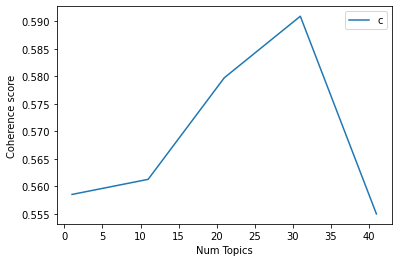

In [14]:
plt.plot(range(start,limit,step), coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence values"), loc="best")
plt.show()

In [15]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_topics=5, num_words=5)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(23,
  '0.045*"line" + 0.044*"organization" + 0.040*"university" + 0.028*"nntp_poste" + 0.024*"host"'),
 (1,
  '0.023*"space" + 0.008*"earth" + 0.007*"launch" + 0.007*"nasa" + 0.007*"research"'),
 (2,
  '0.031*"do" + 0.008*"many" + 0.008*"number" + 0.007*"european" + 0.007*"run"'),
 (27, '0.830*"ax" + 0.060*"max" + 0.002*"qax" + 0.001*"mq" + 0.001*"mb"'),
 (21, '0.024*"van" + 0.023*"cal" + 0.023*"det" + 0.023*"pit" + 0.022*"tor"')]

In [16]:
''' UNDER CONSTRUCTION - 10% found to be good
import random

rand_corpus = random.sample(corpus, int(len(corpus) / 10))
start=1; limit=50; step=10

model_list, coherence_values = coherence_values_computation(
    corpus=rand_corpus
    ,dictionary=id2word
    ,texts=data_lemmatized
    ,start=start, limit=limit, step=step
)
plt.plot(range(start,limit,step), coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence values"), loc="best")
plt.show()
'''

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


' UNDER CONSTRUCTION - 10% found to be good\nimport random\n\nrand_corpus = random.sample(corpus, int(len(corpus) / 10))\nstart=1; limit=50; step=10\n\nmodel_list, coherence_values = coherence_values_computation(\n    corpus=rand_corpus\n    ,dictionary=id2word\n    ,texts=data_lemmatized\n    ,start=start, limit=limit, step=step\n)\nplt.plot(range(start,limit,step), coherence_values)\nplt.xlabel("Num Topics")\nplt.ylabel("Coherence score")\nplt.legend(("coherence values"), loc="best")\nplt.show()\n'

In [17]:
def dominant_topics(ldamodel=lda_model, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()
    
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True
                )
            else:
                break

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

df_topic_sents_keywords = dominant_topics(ldamodel=optimal_model, corpus=corpus, texts=data)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
df_dominant_topic.head(15)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.4059,"car, bike, line, organization, get, ride, driv...",From: am.umd.edu (wheres my thing) Subject: WH...
1,1,18.0,0.4495,"line, organization, do, get, card, system, pro...",From: arson.u.washington.edu (Guy Kuo) Subject...
2,2,26.0,0.3669,"do, say, get, go, know, people, think, write, ...",From: c.ecn.purdue.edu (Thomas E Willis) Subje...
3,3,18.0,0.3748,"line, organization, do, get, card, system, pro...",From: mber (Joe Green) Subject: Re: Weitek P90...
4,4,5.0,0.3189,"people, right, make, do, law, mean, state, thi...",From: ead-cfa.harvard.edu (Jonathan McDowell) ...
5,5,5.0,0.3236,"people, right, make, do, law, mean, state, thi...",From: ttoulu.tko.vtt.fi (Foxvog Douglas) Subje...
6,6,23.0,0.3004,"line, organization, university, nntp_poste, ho...",From: uads.uchicago.edu (brian manning delaney...
7,7,14.0,0.8362,"drive, scsi, mb, ide, os, controller, bit, bus...",From: ante.nmsu.edu (GRUBB) Subject: Re: IDE v...
8,8,17.0,0.7729,"_, image, file, program, line, version, graphi...",From: csvax.uni.edu Subject: WIn 3.0 ICON HELP...
9,9,18.0,0.4655,"line, organization, do, get, card, system, pro...",From: x1.cso.uiuc.edu (Stan Kerr) Subject: Re:...


In [21]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = [
   'Topic_Number', "Contribution_Perc", "Keywords", "Text"
]
sent_topics_sorteddf_mallet.head()

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Number,Contribution_Perc,Keywords,Text
0,0.0,0.5220,"gun, firearm, crime, weapon, drug, criminal, h...",From: ube.handheld.com (Jim De Arras) Subject:...
1,1.0,0.8926,"space, earth, launch, nasa, research, moon, sc...",From: Leigh Palmer fu.ca> Subject: Re: Orion d...
2,2.0,0.7863,"do, many, number, european, run, motto, americ...",From: avid.wheaton.edu (marcus k baird) Subjec...
3,3.0,0.9135,"do, year, go, get, make, well, think, say, s, ...",From: a.MsState.Edu (Fletcher P Adams) Subject...
4,4.0,0.5589,"church, law, sin, day, father, msg, son, lord,...",From: thena.cs.uga.edu (Paul Hudson Jr) Subjec...


In [22]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
df_dominant_topics = pd.concat(
   [topic_num_keywords, topic_counts, topic_contribution], axis=1
)
df_dominant_topics.columns = [
   'Dominant-Topic', 'Topic-Keywords', 'Num_Documents', 'Perc_Documents'
]
df_dominant_topics

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant-Topic,Topic-Keywords,Num_Documents,Perc_Documents
0.0,9.0,"car, bike, line, organization, get, ride, driv...",39.0,0.0034
1.0,18.0,"line, organization, do, get, card, system, pro...",325.0,0.0287
2.0,26.0,"do, say, get, go, know, people, think, write, ...",70.0,0.0062
3.0,18.0,"line, organization, do, get, card, system, pro...",611.0,0.0540
4.0,5.0,"people, right, make, do, law, mean, state, thi...",64.0,0.0057
...,...,...,...,...
11309.0,26.0,"do, say, get, go, know, people, think, write, ...",NaN,NaN
11310.0,18.0,"line, organization, do, get, card, system, pro...",NaN,NaN
11311.0,18.0,"line, organization, do, get, card, system, pro...",NaN,NaN
11312.0,24.0,"plane, point, buffalo, temple, captain, animat...",NaN,NaN
